# Spread Data Analysis Notebook

This notebook loads and analyzes the spread parquet data generated by the integration script.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Spread Data

In [14]:
# Path to the generated parquet file
data_path = r'C:\Users\krajcovic\Documents\Testing Data\ATS_data\test\parquet_files'
spread_file = 'DEM1-DEM2_spread_fixed.parquet'  # Using the fixed version
full_path = Path(data_path) / spread_file

print(f"📁 Loading data from: {full_path}")
print(f"📊 File exists: {full_path.exists()}")

if full_path.exists():
    try:
        # Load the spread data (try different engines if needed)
        spread_df = pd.read_parquet(full_path, engine='fastparquet')
        print(f"✅ Data loaded successfully with fastparquet")
    except:
        try:
            spread_df = pd.read_parquet(full_path, engine='pyarrow')
            print(f"✅ Data loaded successfully with pyarrow")
        except Exception as e:
            print(f"❌ Failed to load parquet: {e}")
            # Fallback to CSV sample
            csv_file = full_path.with_name('DEM1-DEM2_spread_fixed_sample.csv')
            if csv_file.exists():
                spread_df = pd.read_csv(csv_file, index_col=0, parse_dates=True)
                print(f"✅ Loaded sample data from CSV: {spread_df.shape}")
            else:
                print("❌ No fallback data available")
    
    if 'spread_df' in locals():
        print(f"📊 Shape: {spread_df.shape}")
        print(f"📅 Date range: {spread_df.index.min()} to {spread_df.index.max()}")
else:
    print("❌ File not found. Run the integration script first.")

📁 Loading data from: C:\Users\krajcovic\Documents\Testing Data\ATS_data\test\parquet_files\DEM1-DEM2_spread_fixed.parquet
📊 File exists: True
✅ Data loaded successfully with fastparquet
📊 Shape: (54288, 2)
📅 Date range: 2025-07-01 09:00:03.210000 to 2025-07-03 17:24:59.299000


## 2. Basic Data Overview

In [15]:
if 'spread_df' in locals():
    print("🔍 Data Overview:")
    print(f"Columns: {list(spread_df.columns)}")
    print(f"Index type: {type(spread_df.index)}")
    print(f"Data types: {spread_df.dtypes.to_dict()}")
    print(f"Memory usage: {spread_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    print("\n📊 First 10 rows:")
    display(spread_df.head(10))
    
    print("\n📈 Statistical Summary:")
    display(spread_df.describe())

🔍 Data Overview:
Columns: ['bid', 'ask']
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Data types: {'bid': dtype('float64'), 'ask': dtype('float64')}
Memory usage: 1.24 MB

📊 First 10 rows:


,bid,ask
datetime,,
2025-07-01 09:00:03.210,-8.45,-8.30
2025-07-01 09:00:06.343,-8.47,-8.30
2025-07-01 09:00:07.315,-8.48,-8.30
2025-07-01 09:00:12.878,-8.47,-8.30
2025-07-01 09:00:14.096,-8.48,-8.30
2025-07-01 09:00:17.872,-8.47,-8.30
2025-07-01 09:00:21.185,-8.46,-8.30
2025-07-01 09:00:21.291,-8.46,-8.27
2025-07-01 09:00:21.558,-8.46,-8.26



📈 Statistical Summary:


,bid,ask
count,54288.000000,54288.000000
mean,-7.720439,-7.664503
std,0.464462,0.466334
min,-8.630000,-8.540000
25%,-8.130000,-8.080000
50%,-7.720000,-7.650000
75%,-7.400000,-7.330000
max,-6.740000,-6.600000


## 3. Calculate Additional Metrics

In [16]:
if 'spread_df' in locals():
    # Calculate mid price and spread
    spread_df['mid'] = (spread_df['bid'] + spread_df['ask']) / 2
    spread_df['spread_width'] = spread_df['ask'] - spread_df['bid']
    
    # Calculate returns
    spread_df['mid_return'] = spread_df['mid'].pct_change()
    
    # Add time features
    spread_df['date'] = spread_df.index.date
    spread_df['time'] = spread_df.index.time
    spread_df['hour'] = spread_df.index.hour
    
    print("✅ Additional metrics calculated:")
    print(f"   📊 Mid price range: {spread_df['mid'].min():.3f} to {spread_df['mid'].max():.3f}")
    print(f"   📏 Avg spread width: {spread_df['spread_width'].mean():.3f}")
    print(f"   📈 Mid price volatility: {spread_df['mid_return'].std():.4f}")
    
    display(spread_df[['bid', 'ask', 'mid', 'spread_width']].head())

✅ Additional metrics calculated:
   📊 Mid price range: -8.545 to -6.690
   📏 Avg spread width: 0.056
   📈 Mid price volatility: 0.0019


,bid,ask,mid,spread_width
datetime,,,,
2025-07-01 09:00:03.210,-8.45,-8.3,-8.375,0.15
2025-07-01 09:00:06.343,-8.47,-8.3,-8.385,0.17
2025-07-01 09:00:07.315,-8.48,-8.3,-8.390,0.18
2025-07-01 09:00:12.878,-8.47,-8.3,-8.385,0.17
2025-07-01 09:00:14.096,-8.48,-8.3,-8.390,0.18


## 4. Time Series Visualization

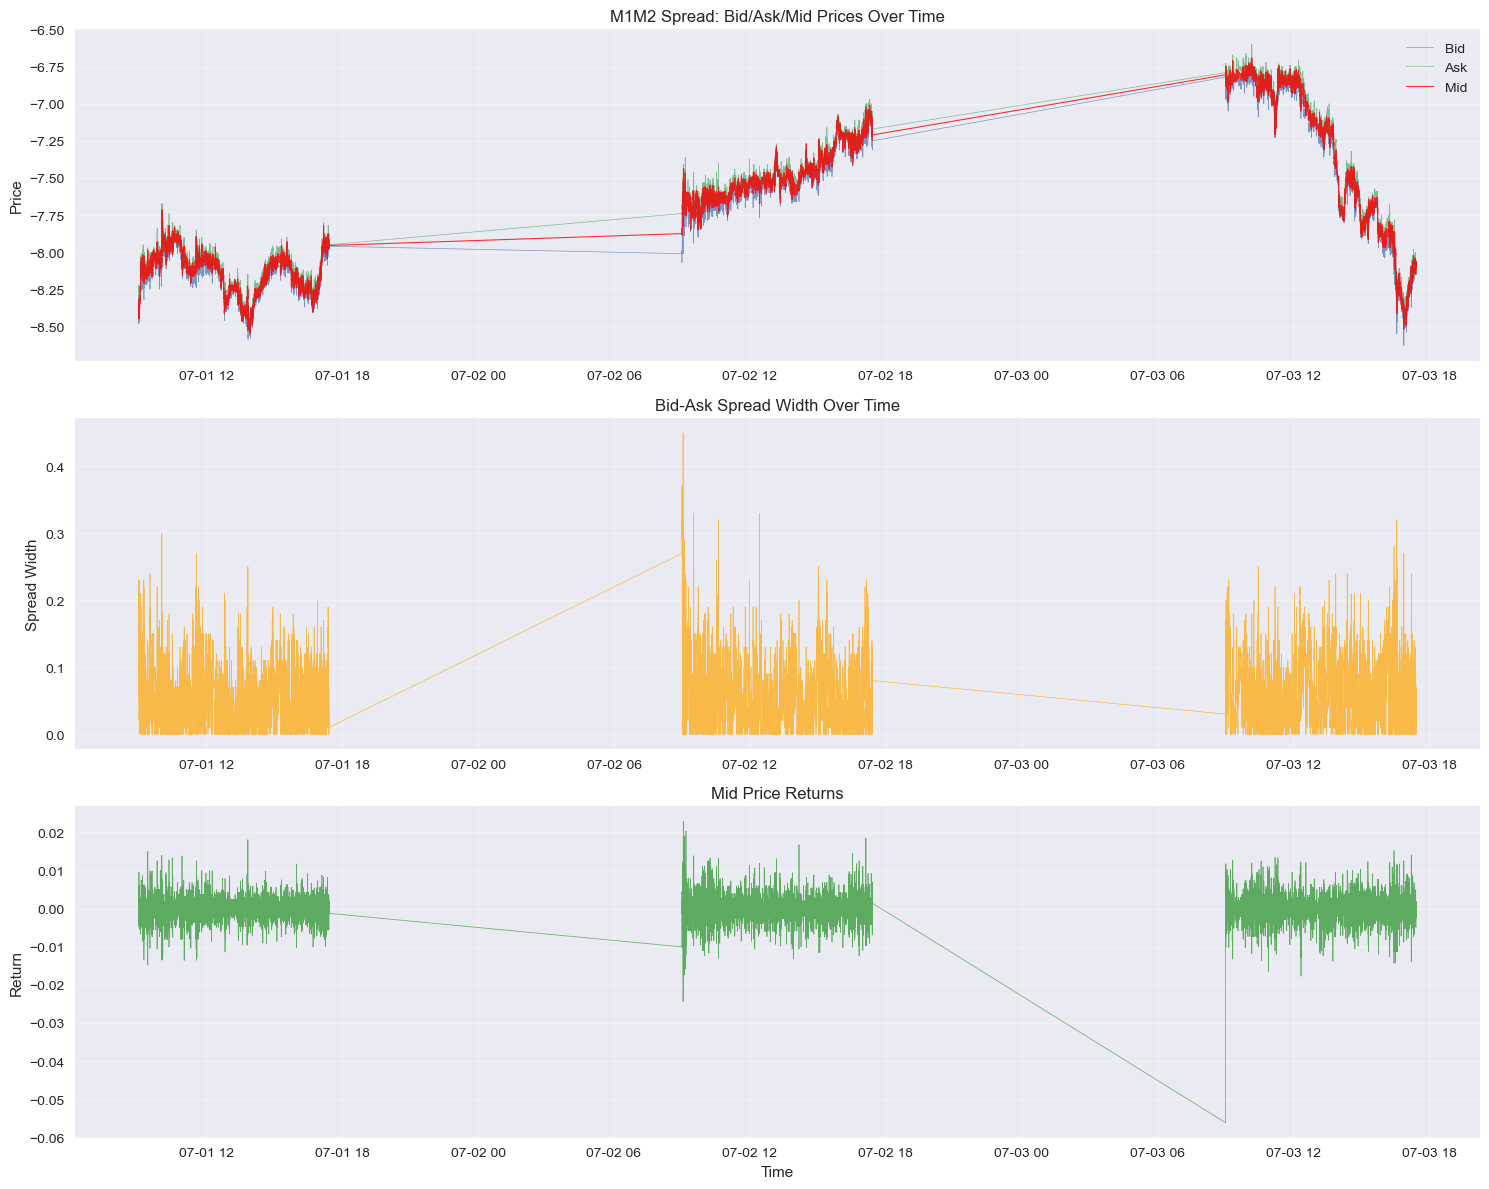

In [17]:
if 'spread_df' in locals():
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot 1: Bid/Ask/Mid over time
    axes[0].plot(spread_df.index, spread_df['bid'], label='Bid', alpha=0.7, linewidth=0.5)
    axes[0].plot(spread_df.index, spread_df['ask'], label='Ask', alpha=0.7, linewidth=0.5)
    axes[0].plot(spread_df.index, spread_df['mid'], label='Mid', alpha=0.8, linewidth=0.8, color='red')
    axes[0].set_title('M1M2 Spread: Bid/Ask/Mid Prices Over Time')
    axes[0].set_ylabel('Price')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Spread width over time
    axes[1].plot(spread_df.index, spread_df['spread_width'], color='orange', alpha=0.7, linewidth=0.5)
    axes[1].set_title('Bid-Ask Spread Width Over Time')
    axes[1].set_ylabel('Spread Width')
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Mid price returns
    returns = spread_df['mid_return'].dropna()
    axes[2].plot(returns.index, returns, color='green', alpha=0.6, linewidth=0.5)
    axes[2].set_title('Mid Price Returns')
    axes[2].set_ylabel('Return')
    axes[2].set_xlabel('Time')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 5. Daily Analysis

📅 Daily Statistics:


,Mid_Min,Mid_Max,Mid_Mean,Mid_Std,Mid_Open,Mid_Close,SpreadWidth_Mean,SpreadWidth_Min,SpreadWidth_Max,Observations,Daily_Return
date,,,,,,,,,,,
2025-07-01,-8.545,-7.715,-8.1341,0.1307,-8.375,-7.955,0.0528,0.0,0.30,20432,-0.0501
2025-07-02,-7.885,-7.010,-7.4783,0.1734,-7.875,-7.210,0.0535,0.0,0.45,17441,-0.0844
2025-07-03,-8.520,-6.690,-7.3703,0.5161,-6.805,-8.075,0.0624,0.0,0.32,16415,0.1866


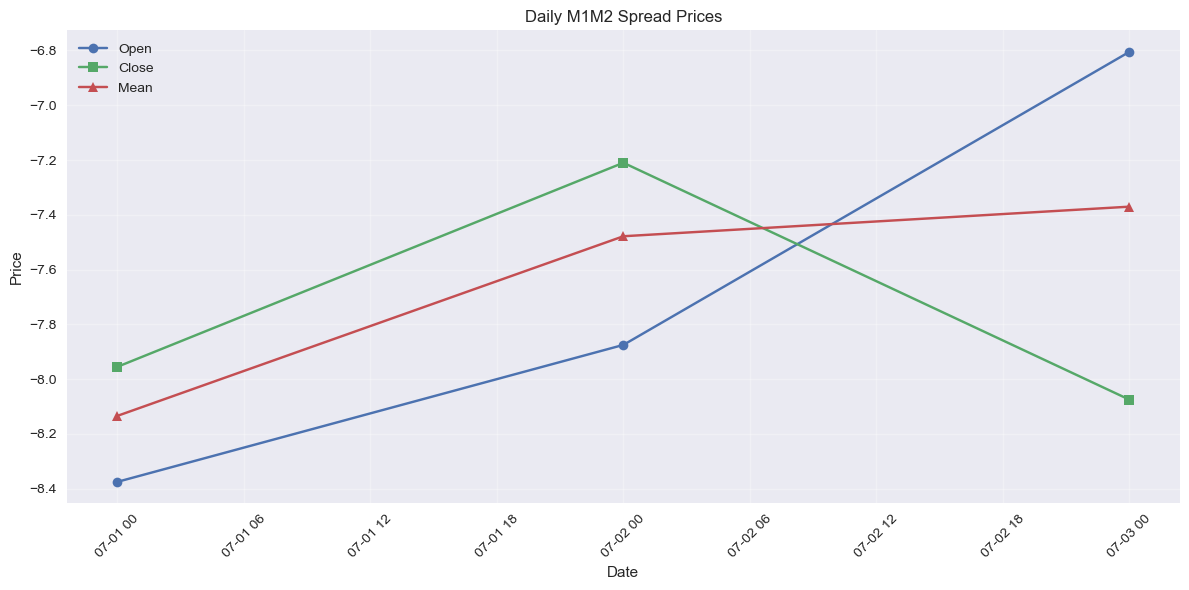

In [18]:
if 'spread_df' in locals():
    # Daily statistics
    daily_stats = spread_df.groupby('date').agg({
        'mid': ['min', 'max', 'mean', 'std', 'first', 'last'],
        'spread_width': ['mean', 'min', 'max'],
        'bid': 'count'  # Number of observations
    }).round(4)
    
    daily_stats.columns = ['Mid_Min', 'Mid_Max', 'Mid_Mean', 'Mid_Std', 'Mid_Open', 'Mid_Close', 
                           'SpreadWidth_Mean', 'SpreadWidth_Min', 'SpreadWidth_Max', 'Observations']
    
    # Calculate daily return
    daily_stats['Daily_Return'] = ((daily_stats['Mid_Close'] / daily_stats['Mid_Open']) - 1).round(4)
    
    print("📅 Daily Statistics:")
    display(daily_stats)
    
    # Plot daily mid prices
    plt.figure(figsize=(12, 6))
    plt.plot(daily_stats.index, daily_stats['Mid_Open'], 'o-', label='Open', marker='o')
    plt.plot(daily_stats.index, daily_stats['Mid_Close'], 's-', label='Close', marker='s')
    plt.plot(daily_stats.index, daily_stats['Mid_Mean'], '^-', label='Mean', marker='^')
    plt.title('Daily M1M2 Spread Prices')
    plt.ylabel('Price')
    plt.xlabel('Date')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 6. Intraday Patterns

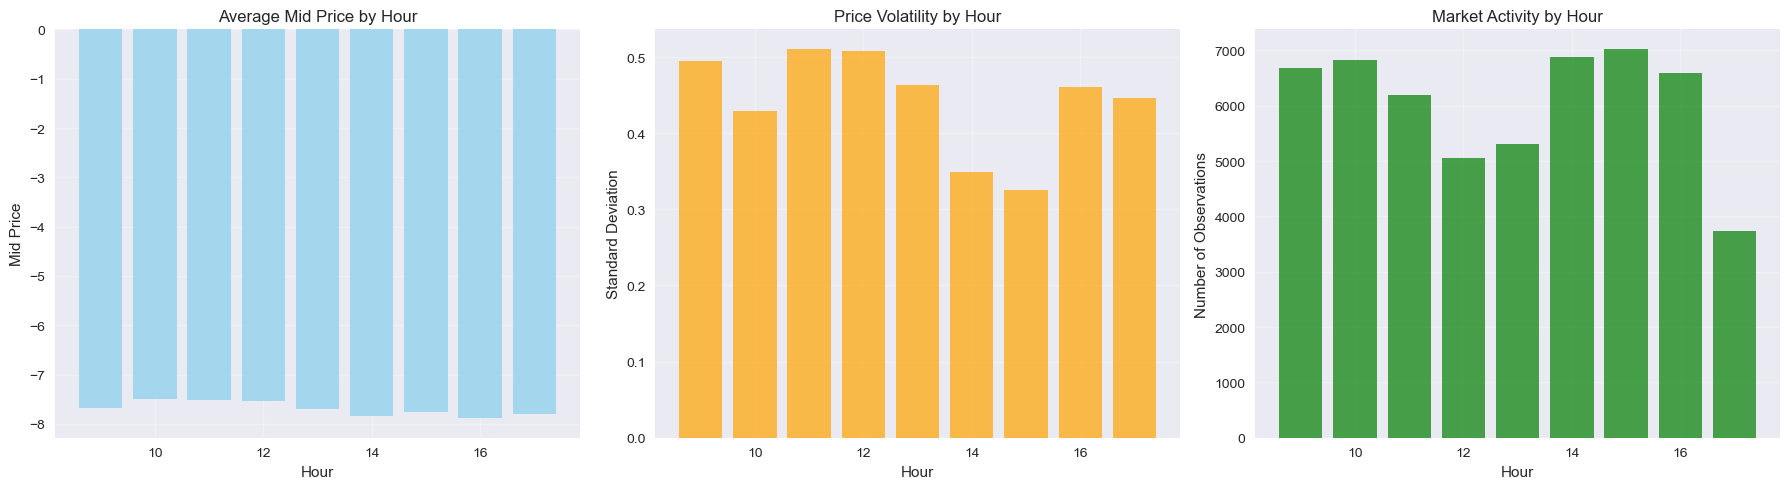

⏰ Hourly Statistics:


,Mid_Mean,Mid_Std,Count,SpreadWidth_Mean
hour,,,,
9,-7.6865,0.4954,6679,0.0725
10,-7.5012,0.4295,6830,0.0485
11,-7.5081,0.5109,6195,0.0579
12,-7.5439,0.5087,5048,0.0587
13,-7.7033,0.4635,5308,0.0544
14,-7.8436,0.3489,6876,0.0474
15,-7.7608,0.3255,7029,0.0596
16,-7.8856,0.4606,6584,0.0504
17,-7.7967,0.4460,3739,0.0535


In [19]:
if 'spread_df' in locals():
    # Hourly statistics
    hourly_stats = spread_df.groupby('hour').agg({
        'mid': ['mean', 'std', 'count'],
        'spread_width': 'mean'
    }).round(4)
    
    hourly_stats.columns = ['Mid_Mean', 'Mid_Std', 'Count', 'SpreadWidth_Mean']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Average mid price by hour
    axes[0].bar(hourly_stats.index, hourly_stats['Mid_Mean'], alpha=0.7, color='skyblue')
    axes[0].set_title('Average Mid Price by Hour')
    axes[0].set_xlabel('Hour')
    axes[0].set_ylabel('Mid Price')
    axes[0].grid(True, alpha=0.3)
    
    # Volatility by hour
    axes[1].bar(hourly_stats.index, hourly_stats['Mid_Std'], alpha=0.7, color='orange')
    axes[1].set_title('Price Volatility by Hour')
    axes[1].set_xlabel('Hour')
    axes[1].set_ylabel('Standard Deviation')
    axes[1].grid(True, alpha=0.3)
    
    # Activity by hour
    axes[2].bar(hourly_stats.index, hourly_stats['Count'], alpha=0.7, color='green')
    axes[2].set_title('Market Activity by Hour')
    axes[2].set_xlabel('Hour')
    axes[2].set_ylabel('Number of Observations')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("⏰ Hourly Statistics:")
    display(hourly_stats)

## 7. Distribution Analysis

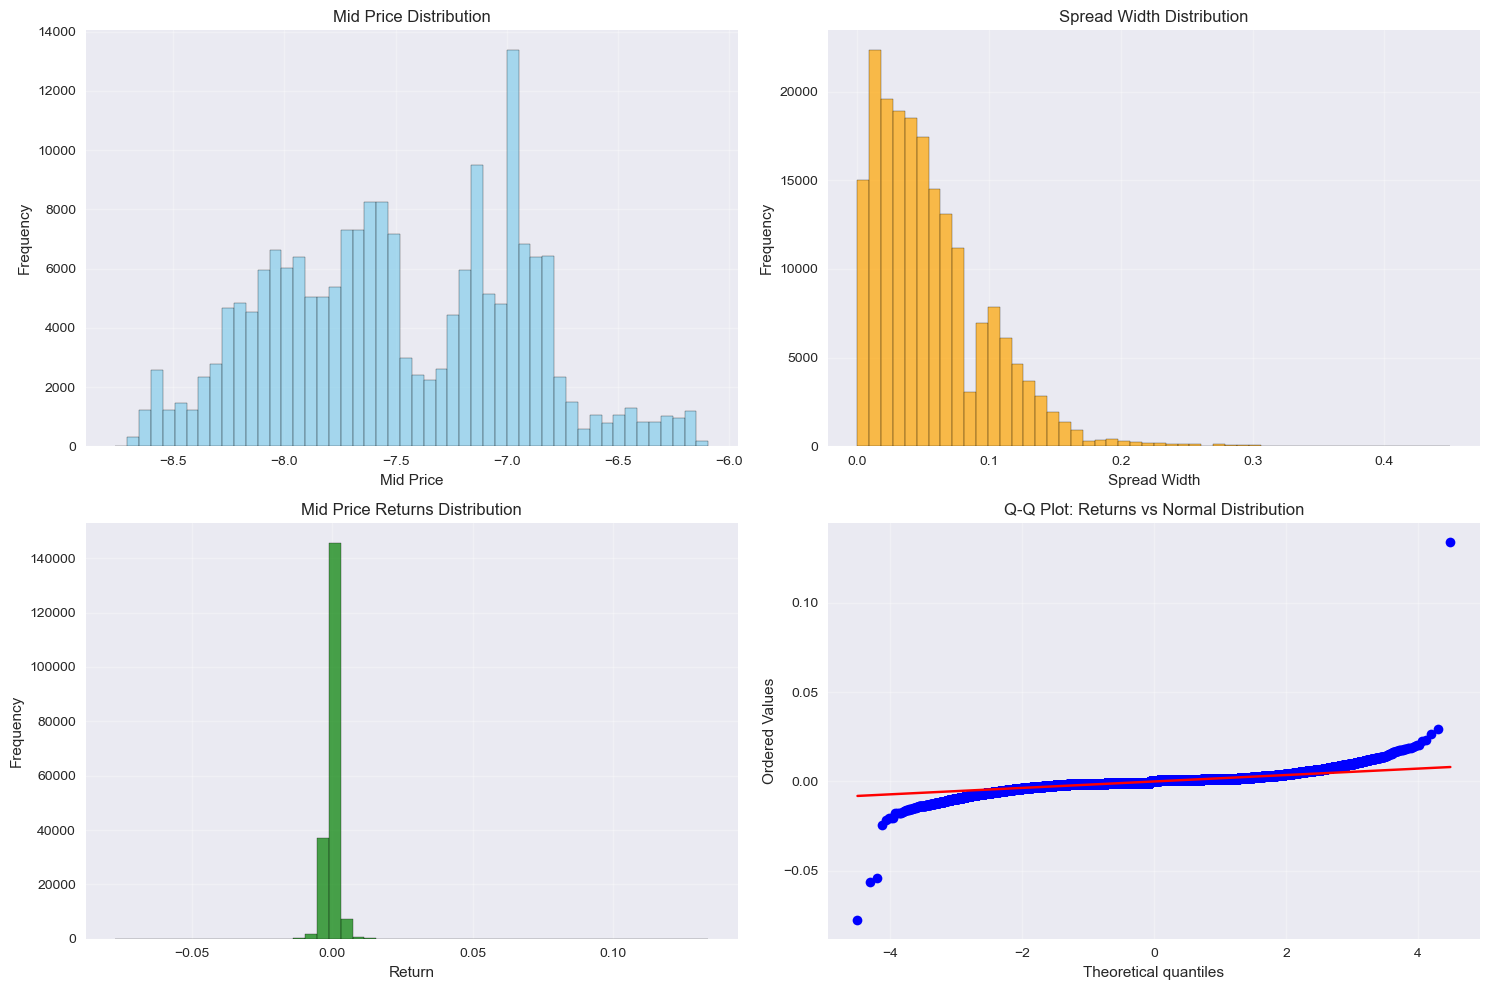

📊 Distribution Statistics:
Mid Price - Mean: -7.4969, Std: 0.5503
Spread Width - Mean: 0.0546, Std: 0.0437
Returns - Mean: 0.000002, Std: 0.001934
Returns Skewness: 1.2857
Returns Kurtosis: 147.9767


In [11]:
if 'spread_df' in locals():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Mid price distribution
    axes[0,0].hist(spread_df['mid'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].set_title('Mid Price Distribution')
    axes[0,0].set_xlabel('Mid Price')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].grid(True, alpha=0.3)
    
    # Spread width distribution
    axes[0,1].hist(spread_df['spread_width'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[0,1].set_title('Spread Width Distribution')
    axes[0,1].set_xlabel('Spread Width')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].grid(True, alpha=0.3)
    
    # Returns distribution
    returns = spread_df['mid_return'].dropna()
    axes[1,0].hist(returns, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1,0].set_title('Mid Price Returns Distribution')
    axes[1,0].set_xlabel('Return')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid(True, alpha=0.3)
    
    # Q-Q plot for returns normality
    from scipy import stats
    stats.probplot(returns, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot: Returns vs Normal Distribution')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Distribution Statistics:")
    print(f"Mid Price - Mean: {spread_df['mid'].mean():.4f}, Std: {spread_df['mid'].std():.4f}")
    print(f"Spread Width - Mean: {spread_df['spread_width'].mean():.4f}, Std: {spread_df['spread_width'].std():.4f}")
    print(f"Returns - Mean: {returns.mean():.6f}, Std: {returns.std():.6f}")
    print(f"Returns Skewness: {returns.skew():.4f}")
    print(f"Returns Kurtosis: {returns.kurtosis():.4f}")

## 8. Export Processed Data

In [12]:
if 'spread_df' in locals():
    # Save the enhanced dataset
    output_path = Path(data_path) / 'DEM1-DEM2_spread_enhanced.parquet'
    
    # Select relevant columns for export
    export_columns = ['bid', 'ask', 'mid', 'spread_width', 'mid_return']
    export_df = spread_df[export_columns].copy()
    
    export_df.to_parquet(output_path)
    print(f"💾 Enhanced dataset saved: {output_path}")
    print(f"📊 Exported {len(export_df)} rows with {len(export_columns)} columns")
    
    # Save daily statistics
    daily_stats_path = Path(data_path) / 'DEM1-DEM2_daily_stats.csv'
    daily_stats.to_csv(daily_stats_path)
    print(f"📅 Daily statistics saved: {daily_stats_path}")
    
    # Save hourly statistics
    hourly_stats_path = Path(data_path) / 'DEM1-DEM2_hourly_stats.csv'
    hourly_stats.to_csv(hourly_stats_path)
    print(f"⏰ Hourly statistics saved: {hourly_stats_path}")

💾 Enhanced dataset saved: C:\Users\krajcovic\Documents\Testing Data\ATS_data\test\parquet_files\DEM1-DEM2_spread_enhanced.parquet
📊 Exported 192632 rows with 5 columns
📅 Daily statistics saved: C:\Users\krajcovic\Documents\Testing Data\ATS_data\test\parquet_files\DEM1-DEM2_daily_stats.csv
⏰ Hourly statistics saved: C:\Users\krajcovic\Documents\Testing Data\ATS_data\test\parquet_files\DEM1-DEM2_hourly_stats.csv


## 9. Summary Report

In [ ]:
if 'spread_df' in locals():
    print("📋 M1M2 Spread Analysis Summary")
    print("=" * 50)
    print(f"📊 Dataset: {spread_df.shape[0]:,} observations over {len(spread_df.groupby('date'))} days")
    print(f"📅 Period: {spread_df.index.min().strftime('%Y-%m-%d')} to {spread_df.index.max().strftime('%Y-%m-%d')}")
    print(f"⏰ Trading hours: {spread_df['hour'].min()}:00 to {spread_df['hour'].max()}:00")
    print(f"📈 Price range: {spread_df['mid'].min():.3f} to {spread_df['mid'].max():.3f}")
    print(f"📏 Avg spread width: {spread_df['spread_width'].mean():.3f}")
    print(f"📊 Daily volatility: {(returns.std() * np.sqrt(len(returns))):.4f}")
    print(f"🎯 Most active hour: {hourly_stats['Count'].idxmax()}:00 ({hourly_stats['Count'].max():,} obs)")
    print(f"💹 Best performing day: {daily_stats['Daily_Return'].idxmax()} ({daily_stats['Daily_Return'].max()*100:.2f}%)")
    print(f"📉 Worst performing day: {daily_stats['Daily_Return'].idxmin()} ({daily_stats['Daily_Return'].min()*100:.2f}%)")
    
    print("\n✅ Analysis completed successfully!")
else:
    print("❌ No data loaded. Please run the cells above to load the spread data first.")